# TensorFlow Probability

tensorflow ==1.15
tensorflow-probability==0.7.0

是一种提供先进贝叶斯建模的概率编程工具
<br>本文主要针对贝叶斯结构时间序列/Structural time series (STS)这个模块
<br> 后验概率=（先验概率*似然函数）/观测值


**概述**
* 0-layer:TensorFlow的数值运算。特别是，LinearOperator类实现了无矩阵计算，可以利用特殊结构（对角线，低秩矩阵等）进行高效计算
* 1-layer:统计构建模块。包括：
<br> 分布（tf.contrib.distributions，tf.distributions）
<br> Bijectors（tf.contrib.distributions.bijectors）:支持随机变量的可逆和可组合变换。Bijectors提供了丰富的变换分布类别，从经典的例子（如对数正态分布）到复杂的深度学习模型（如masked自回归流）
* 2-layer:模型构建
<br> Edward2（tfp.edward2）：一种用于将灵活的概率模型指定为程序的概率编程语言
<br> 概率图层（tfp.layers）
<br> 可训练分布（tfp.trainable_distributions）：由单个张量参数化的概率分布，使建立输出概率分布的神经网络变得容易
* 3-layer:概率推理
<br> 马尔可夫链Monte Carlo（tfp.mcmc）：通过采样来近似积分的算法。包括Hamiltonian Monte Carlo，随机游走Metropolis-Hastings，以及构建自定义过渡内核的能力
<br> 变分推理（tfp.vi）：通过优化来近似积分的算法
<br> 优化器（tfp.optimizer）：随机优化方法，扩展TensorFlow优化器，包括随机梯度Langevin动力学
<br> 蒙特卡洛（tfp.monte_carlo）：用于计算蒙特卡罗期望的工具
* 4-layer:预制模型和推理
<br> 贝叶斯结构时间序列：用于拟合时间序列模型的高级接口（即类似于R的BSTS包）
<br> 广义线性混合模型：用于拟合混合效应回归模型的高级界面（即与R的lme4软件包相似）




## 主要步骤：
1. 将训练数据输入-输出映射；
2. 使用变分推断拟合模型，抽样计算参数后验分布；常用的优化/损失函数为ELBO（negative evidence lower bound），通过循环迭代直至收敛，得到变分参数
3. 得到模型预测值；
4. 计算模型评估指标MAPE；
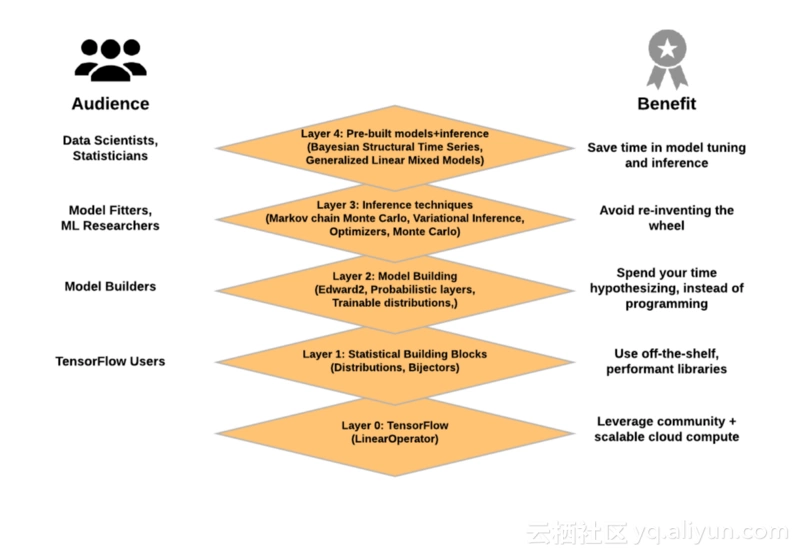

In [1]:
# 用正态分布作为先验分布，使用negative evidence lower bound (ELBO)作为损失函数，通过tfp.sts 计算后验
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts


In [33]:
#绘制预测与真实值时间序列图
def plot_forecast(x, y,test_dates,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast
    

    ax.plot(x, y, lw=2, color=c1, label='ground truth')
    forecast_steps = test_dates.copy()
    print('forecast_steps:',forecast_steps)
    print('forecast_samples:',forecast_samples)
    print('forecast_mean:',forecast_mean)
    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)
    #绘制预测期望值以及针对预测天数的100个采样结果
    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color='r',
           label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()
 
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
        
    return fig, ax

In [3]:
#建构模型，并计算计算损失函数
def cal_loss(training_data):
    
    #设置全局默认图形
    tf.reset_default_graph()
    #遵循加法模型，设置趋势
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    
    #设置季节性
    seasonal = tfp.sts.Seasonal(
          num_seasons=12, observed_time_series=observed_time_series)
    #模型拟合,之所以用sum，而不是我们在建模中常见的fit定义，是因为，
    #模型时间序列为加法模型，有如上文提到的趋势，季节性，周期性等成分相加
    #默认的先验分布为正态（normal）
    ts_model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)

    #构建变分损失函数和后验
    with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
        elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
          ts_model,observed_time_series=training_data)
    
    return ts_model,elbo_loss,variational_posteriors

In [4]:
#模型训练，输出后验分布
def run(training_data):
    
    ts_model,elbo_loss,variational_posteriors=cal_loss(training_data)
    num_variational_steps = 401 
    num_variational_steps = int(num_variational_steps)

    #训练模型，ELBO作为在变分推断的损失函数
    train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)
    
    #创建会话,并通过上下文管理器方式对张量Tensor对象进行计算
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(num_variational_steps):
            _, elbo_ = sess.run((train_vi, elbo_loss))
            
        if i % 20 == 0:
            print("step {} -ELBO {}".format(i, elbo_))
        #求解后验参数
        q_samples_ = sess.run({k: q.sample(3)
                             for k, q in variational_posteriors.items()})
        
        
        print("打印变分推断参数信息:")
        for param in ts_model.parameters:
            print("{}: {} +- {}".format(param.name,
                      np.mean(q_samples_[param.name], axis=0),
                      np.std(q_samples_[param.name], axis=0)))

    data_t_dist = tfp.sts.forecast(ts_model,observed_time_series=training_data,\
                                   parameter_samples=q_samples_,num_steps_forecast=num_forecast_steps)
    return  data_t_dist

In [17]:
#模型预测
def forecast(training_data):
    data_t_dist=run(training_data)
    print('后验分布：',data_t_dist)
    with tf.Session() as sess:
        data_t_mean, data_t_scale, data_t_samples = sess.run(
          (data_t_dist.mean()[..., 0],
           data_t_dist.stddev()[..., 0],
           data_t_dist.sample(num_samples)[..., 0]))
    return data_t_mean,data_t_scale, data_t_samples

In [18]:
#计算回测
def get_mape(data_t,forecsat):
    true_=data_t[-num_forecast_steps:]
    true_=true_.iloc[:,-1]
    true_=true_.reset_index()
    forecsat=pd.DataFrame(forecsat,columns=['focecast'])
    mape_=pd.concat([pd.DataFrame(true_),forecsat],axis=1)
    mape_['mape']=abs(mape_.iloc[:,-2]-mape_.iloc[:,-1])/mape_.iloc[:,-2]*100
    return mape_

In [19]:
def time2stamp(cmnttime):   #转时间戳函数
    cmnttime=str(cmnttime)
    cmnttime=datetime.strptime(cmnttime,'%Y%m%d')
    return cmnttime

序列长度 105
step 400 -ELBO 95.07475006798529
打印变分推断参数信息:
observation_noise_scale: 0.05148333036587855 +- 0.030335569878877137
LocalLinearTrend/_level_scale: 0.46030387670183065 +- 0.04099451471199704
LocalLinearTrend/_slope_scale: 0.029455283395983165 +- 0.021311852272227913
Seasonal/_drift_scale: 0.19487417135512466 +- 0.047049047274538604
后验分布： tfp.distributions.MixtureSameFamily("forecast/MixtureSameFamily/", batch_shape=[], event_shape=[30, 1], dtype=float64)
forecast_steps: ['2020-01-20' '2020-01-21' '2020-01-22' '2020-01-23' '2020-01-24'
 '2020-01-29' '2020-01-30' '2020-01-31' '2020-02-03' '2020-02-04'
 '2020-02-05' '2020-02-06' '2020-02-07' '2020-02-10' '2020-02-11'
 '2020-02-12' '2020-02-13' '2020-02-14' '2020-02-17' '2020-02-18'
 '2020-02-19' '2020-02-20' '2020-02-21' '2020-02-24' '2020-02-25'
 '2020-02-26' '2020-02-27' '2020-02-28' '2020-03-02' '2020-03-03']
forecast_samples: [[24.78685237 23.43784599 23.94401702 ... 12.80967955 12.41711572
  12.49741142]
 [25.98962507 26.117048

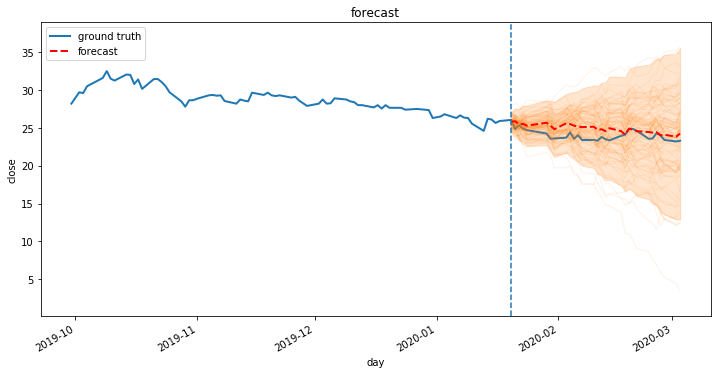

In [34]:
from datetime import datetime
from datetime import timedelta
import warnings
import math
warnings.filterwarnings('ignore')

if __name__ == '__main__':
    
    #读取数据集
    data_t=pd.read_csv("./dataset/BUD_HK.csv")
    data_t=data_t[['close','date']]
    data_t['date']=data_t['date'].apply(time2stamp)
    
    data_t=data_t.sort_values(by='date')
    data_t.reset_index(inplace=True,drop=True)
    data_t=data_t.set_index('date')
    
    print('序列长度',len(data_t))
    
    #设置超参数
    num_forecast_steps =30 # 最后30天作为预测值，以便于计算回测mape
    num_samples=100    #设定采样次数
    
    training_data = data_t[:-num_forecast_steps]
    data_dates=np.array(data_t.index,dtype='datetime64[D]')
    test_dates=np.array(data_t[-num_forecast_steps:].index,dtype='datetime64[D]')
    
    observed_time_series=training_data
    
    data_t_mean,data_t_scale, data_t_samples=forecast(training_data)
    
    data_y=pd.Series(data_t['close'])
    
    fig, ax = plot_forecast(data_dates, data_y,test_dates,data_t_mean,data_t_scale, data_t_samples,title="forecast")
    
    
    ax.axvline(data_dates[-num_forecast_steps], linestyle="--")
    ax.legend(loc="upper left")
    ax.set_ylabel("close")
    ax.set_xlabel("day")
    fig.autofmt_xdate()
    
    mape=get_mape(data_t,data_t_mean)
    print(mape)
    print('mape:',mape['mape'].mean())